<a href="https://colab.research.google.com/github/Culeshovi/deep-learning/blob/master/lungi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Abstract

Convolutional Neural Networks have outperformed traditional techniques in many visual recognition tasks over the years. In this paper we put forward a novel approach of lung segmentation using Convolutional Neural Networks. In the traditional methods, the features of the images to be recognised and then segmented are often hardcoded. This is might seem quite simple at first and easy to implement but then as the complexity of the problems increase, these methods start to crumble. Moreover these methods do not handle edge cases accurately as the programs do not know what to do when the images deviate from the expected nature. This is where Deep Learning methods (CNNs in our case) comes to the rescue. Instead of hardcoding, we can build a CNN which has to be fed with a preferably large dataset consisting of CT images and the segmented images of the lungs and then fed to the CNN. The CNN then automatically detects the features and the accuracy can be increased by tuning the parameters and other techniques. The model once trained can be used to segment on new CT images. This approach gives a much higher accuracy compared to traditional methods on testing datasets and ultimately paving the way to a better analysis of the lungs.

## Introduction

Computed Tomography (abbreviated as CT) is a widely used technique in the field of medical imaging. Since most of the CT images are nowadays digital, many advanced image processing techniques can be used which makes it easier to substantially increase the quality of the images and thus extract much more information out of them. In a CT scan, X-rays are used to obtain cross-sectional images of the object being scanned from various angles after which digital geometry processing is used to generate three-dimensional image of the volume of the object from a series of two-dimensional radiographic images.

The first step in the analysis of the CT image is the segmentation of the organ of interest, in our case the lung. This segmentation can be done either manually or automatically with the help of machines. Segmentation is a vital step in the treatment of the disease and errors in this step can lead to loss of lives. With the rapid advancement of technology, in the 21st century we are in a position to automate this task with the help of machines and also perfecting it's working over time. Over the years many techniques have been employed like thresholding based segmentation, region based segmentation, neighboring anatomy-guided segmentation etc. In this paper, we have proposed a Convolutional Neural Network (CNN) based segmentation which gives quite high accuracy compared to traditional methods.

## Download dataset from kaggle

In [0]:
!pip install kaggle

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(


q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)






Download 100%.


## Implementation

In [0]:
!kaggle datasets download -d kmader/finding-lungs-in-ct-data -p /content/kaggle

 98%|███████████████████████████████████████▍| 521M/529M [00:06<00:00, 93.5MB/s]
100%|████████████████████████████████████████| 529M/529M [00:06<00:00, 86.7MB/s]


### Load dataset

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("../content/kaggle/finding-lungs-in-ct-data.zip",'r')
zip_ref.extractall("../content/kaggle/")
zip_ref.close()

In [0]:
import os
import numpy as np
np.random.seed(123)
import pandas as pd

from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import keras.backend as K

from keras.models import Sequential,Model


from keras.layers import MaxPooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D,BatchNormalization,UpSampling2D,Conv2DTranspose
from keras.utils import np_utils

from skimage.io import imread
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
K.set_image_dim_ordering('th')
jimread = lambda x: np.expand_dims(imread(x)[::4, ::4],0)

In [0]:
os.chdir('kaggle')

datalab  kaggle


In [0]:

all_images = glob(os.path.join('2d_images', '*.tif'))
all_masks = ['_masks'.join(c_file.split('_images')) for c_file in all_images]
print(len(all_masks), 'matching files found')


267 matching files found


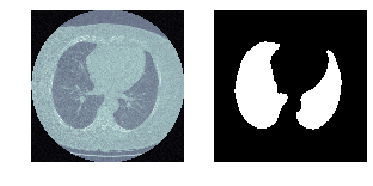

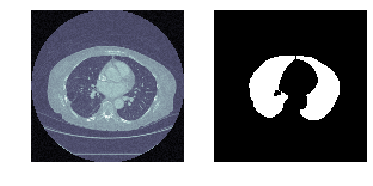

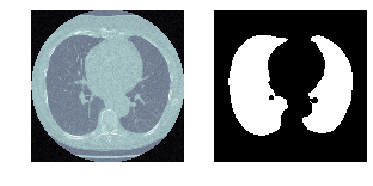

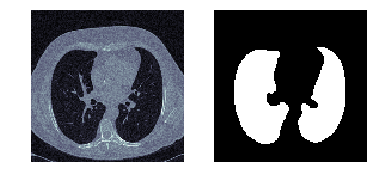

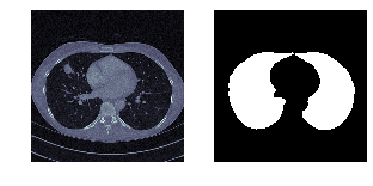

In [0]:
%matplotlib inline



tick=5
while (tick>0):
  test_image = jimread(all_images[tick])
  test_mask = jimread(all_masks[tick])
  fig, (ax1 ,ax2) = plt.subplots(1, 2)
  ax1.imshow(test_image[0],cmap='bone')
  ax2.imshow(test_mask[0],cmap='bone')
  ax1.axis('off')
  ax2.axis('off')
  tick=tick-1


In [0]:


print('Total samples are', len(all_images))
print('Image resolution is', test_image.shape)



Total samples are 267
Image resolution is (1, 128, 128)


### Define test and train set

In [0]:
images = np.stack([jimread(i) for i in all_images], 0)
masks = np.stack([jimread(i) for i in all_masks], 0) / 255.0
X_train, X_test, y_train,  y_test = train_test_split(images, masks, test_size=0.1)
print('Training input is', X_train.shape)
print('Training output is {}, min is {}, max is {}'.format(y_train.shape, y_train.min(), y_train.max()))
print('Testing set is', X_test.shape)



Training input is (240, 1, 128, 128)
Training output is (240, 1, 128, 128), min is 0.0, max is 1.0
Testing set is (27, 1, 128, 128)


### Network model
![model](https://image.ibb.co/hgxxZ8/net.jpg)

In [0]:
in_lay=Input(X_train.shape[1:])

l1=Conv2D(64, kernel_size = (4,4),strides=2, padding = 'same',activation = 'relu',data_format="channels_first")(in_lay)
l1=BatchNormalization()(l1)

l1=Conv2D(128, kernel_size = (4,4),strides=2, padding = 'same',activation = 'relu',data_format="channels_first")(l1)  #ENCODER
l1=BatchNormalization()(l1)

l1=Conv2D(256, kernel_size = (4,4),strides=2, padding = 'same',activation = 'relu',data_format="channels_first")(l1)
l1=BatchNormalization()(l1)

#l1=Conv2D(512, kernel_size = (4,4),strides=2, padding = 'same',activation = 'relu',data_format="channels_first")(l1)
#l1=BatchNormalization()(l1)

#l1=Conv2D(1024, kernel_size = (4,4),strides=2, padding = 'same',activation = 'relu',data_format="channels_first")(l1)
#l1=BatchNormalization()(l1)

#l2=Conv2D(2048, kernel_size = (4,4),strides=2, padding = 'same',activation = 'relu',data_format="channels_first")(l1) #CENTER
#l2=BatchNormalization()(l2)

#l3=Conv2D(1024, kernel_size = (4,4),strides=1, padding = 'same',activation = 'relu',data_format="channels_first")(l2)
#l3=UpSampling2D(size=(2, 2))(l3)                                                              #DECODER
#l3=BatchNormalization()(l3)

#l3=Conv2D(512, kernel_size = (4,4),strides=1, padding = 'same',activation = 'relu',data_format="channels_first")(l3)
#l3=UpSampling2D(size=(2, 2))(l3)
#l3=BatchNormalization()(l3)

#l3=Conv2D(512, kernel_size = (4,4),strides=1, padding = 'same',activation = 'relu',data_format="channels_first")(l3)
#l3=UpSampling2D(size=(2, 2))(l3)
#l3=BatchNormalization()(l3)

#l3=Conv2D(256, kernel_size = (4,4),strides=1, padding = 'same',activation = 'relu',data_format="channels_first")(l1)
#l3=UpSampling2D(size=(2, 2))(l3)
#l3=BatchNormalization()(l3)


#l3=Conv2D(64, kernel_size = (4,4),strides=1, padding = 'same',activation = 'relu',data_format="channels_first")(l1)
#l3=UpSampling2D(size=(2, 2))(l3)

l3=Conv2DTranspose(128, kernel_size = (4,4),strides=2, padding = 'same',activation = 'relu',data_format="channels_first")(l1)
l3=BatchNormalization()(l3)



l3=Conv2DTranspose(64, kernel_size = (4,4),strides=2, padding = 'same',activation = 'relu',data_format="channels_first")(l3)
l3=BatchNormalization()(l3)

#Out=Conv2D(1, kernel_size = (4,4),strides=1, padding = 'same',activation = 'relu',data_format="channels_first")(l3)
#Out=UpSampling2D(size=(2, 2))(Out)
Out=Conv2DTranspose(1, kernel_size = (4,4),strides=2, padding = 'same',activation = 'relu',data_format="channels_first")(l3)
Out=BatchNormalization()(Out)
model=Model(inputs = [in_lay], outputs = [Out])
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy',
                           metrics=['accuracy','mse'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 128, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1088      
_________________________________________________________________
batch_normalization_11 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 32, 32)       131200    
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 32, 32)       128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 16, 16)       524544    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256, 16, 16)       64        
__________

### Prepare to run network

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('lung_result')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0000001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=150)
callbacks_list = [checkpoint, early, reduceLROnPlat,] 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


### Run network for training

In [0]:
hist=model.fit(X_train, y_train, steps_per_epoch=12,validation_data = (X_test, y_test),epochs=150,callbacks = callbacks_list,validation_steps=3)

Train on 240 samples, validate on 27 samples
Epoch 1/150
12/12 [==============================] - 10s 855ms/step - loss: 3.5962 - acc: 0.4217 - mean_squared_error: 1.1927 - val_loss: 2.5761 - val_acc: 0.5055 - val_mean_squared_error: 1.4511

Epoch 00001: val_loss improved from inf to 2.57613, saving model to lung_result_weights.best.hdf5
Epoch 2/150
12/12 [==============================] - 9s 751ms/step - loss: 2.3754 - acc: 0.5402 - mean_squared_error: 1.1129 - val_loss: 3.0540 - val_acc: 0.4331 - val_mean_squared_error: 4.5916

Epoch 00002: val_loss did not improve from 2.57613
Epoch 3/150
12/12 [==============================] - 9s 749ms/step - loss: 2.0883 - acc: 0.5597 - mean_squared_error: 1.0767 - val_loss: 2.4072 - val_acc: 0.4836 - val_mean_squared_error: 2.7739

Epoch 00003: val_loss improved from 2.57613 to 2.40716, saving model to lung_result_weights.best.hdf5
Epoch 4/150
12/12 [==============================] - 9s 753ms/step - loss: 1.4913 - acc: 0.5891 - mean_squared_erro

12/12 [==============================] - 9s 750ms/step - loss: 0.7553 - acc: 0.5834 - mean_squared_error: 0.8854 - val_loss: 3.5309 - val_acc: 0.1970 - val_mean_squared_error: 2.2860

Epoch 00008: val_loss did not improve from 1.19613
Epoch 9/150
12/12 [==============================] - 9s 748ms/step - loss: 0.4955 - acc: 0.6267 - mean_squared_error: 0.8315 - val_loss: 3.2565 - val_acc: 0.1855 - val_mean_squared_error: 25.7625

Epoch 00009: val_loss did not improve from 1.19613
Epoch 10/150
12/12 [==============================] - 9s 749ms/step - loss: 0.4284 - acc: 0.6403 - mean_squared_error: 0.8269 - val_loss: 4.5756 - val_acc: 0.1081 - val_mean_squared_error: 4.8584

Epoch 00010: val_loss did not improve from 1.19613
Epoch 11/150
12/12 [==============================] - 9s 749ms/step - loss: 0.3656 - acc: 0.6703 - mean_squared_error: 0.8209 - val_loss: 1.3758 - val_acc: 0.4068 - val_mean_squared_error: 1.8685

Epoch 00011: val_loss did not improve from 1.19613
Epoch 12/150
12/12 [=

12/12 [==============================] - 9s 749ms/step - loss: 0.4459 - acc: 0.6567 - mean_squared_error: 0.7905 - val_loss: 0.9327 - val_acc: 0.3651 - val_mean_squared_error: 12.0591

Epoch 00015: val_loss did not improve from 0.71052
Epoch 16/150
12/12 [==============================] - 9s 749ms/step - loss: 0.2834 - acc: 0.6968 - mean_squared_error: 0.7793 - val_loss: 0.6052 - val_acc: 0.4040 - val_mean_squared_error: 3.0076

Epoch 00016: val_loss improved from 0.71052 to 0.60521, saving model to lung_result_weights.best.hdf5
Epoch 17/150
12/12 [==============================] - 9s 747ms/step - loss: 0.2473 - acc: 0.6874 - mean_squared_error: 0.7544 - val_loss: 0.4463 - val_acc: 0.4093 - val_mean_squared_error: 6.7571

Epoch 00017: val_loss improved from 0.60521 to 0.44626, saving model to lung_result_weights.best.hdf5
Epoch 18/150
12/12 [==============================] - 9s 748ms/step - loss: 0.2561 - acc: 0.6785 - mean_squared_error: 0.7514 - val_loss: 0.3628 - val_acc: 0.4854 - v

12/12 [==============================] - 9s 747ms/step - loss: 0.2407 - acc: 0.6705 - mean_squared_error: 0.7511 - val_loss: 0.1833 - val_acc: 0.5783 - val_mean_squared_error: 1.3067

Epoch 00022: val_loss improved from 0.21408 to 0.18333, saving model to lung_result_weights.best.hdf5
Epoch 23/150
12/12 [==============================] - 9s 749ms/step - loss: 0.2462 - acc: 0.6729 - mean_squared_error: 0.7365 - val_loss: 0.4145 - val_acc: 0.4532 - val_mean_squared_error: 4.6009

Epoch 00023: val_loss did not improve from 0.18333
Epoch 24/150
12/12 [==============================] - 9s 748ms/step - loss: 0.2409 - acc: 0.6699 - mean_squared_error: 0.7339 - val_loss: 0.4870 - val_acc: 0.4681 - val_mean_squared_error: 2.6086

Epoch 00024: val_loss did not improve from 0.18333
Epoch 25/150
12/12 [==============================] - 9s 750ms/step - loss: 0.1741 - acc: 0.6893 - mean_squared_error: 0.7156 - val_loss: 0.1458 - val_acc: 0.6352 - val_mean_squared_error: 0.5482

Epoch 00025: val_loss

12/12 [==============================] - 9s 751ms/step - loss: 0.1810 - acc: 0.6488 - mean_squared_error: 0.6784 - val_loss: 1.3288 - val_acc: 0.4579 - val_mean_squared_error: 1.2617

Epoch 00029: val_loss did not improve from 0.10289
Epoch 30/150
12/12 [==============================] - 9s 749ms/step - loss: 0.1532 - acc: 0.6944 - mean_squared_error: 0.6890 - val_loss: 0.1459 - val_acc: 0.5781 - val_mean_squared_error: 0.4099

Epoch 00030: val_loss did not improve from 0.10289
Epoch 31/150
12/12 [==============================] - 9s 748ms/step - loss: 0.2084 - acc: 0.6719 - mean_squared_error: 0.6869 - val_loss: 0.1874 - val_acc: 0.4964 - val_mean_squared_error: 1.4326

Epoch 00031: val_loss did not improve from 0.10289
Epoch 32/150
12/12 [==============================] - 9s 749ms/step - loss: 0.1378 - acc: 0.6770 - mean_squared_error: 0.6759 - val_loss: 0.0966 - val_acc: 0.5406 - val_mean_squared_error: 0.5975

Epoch 00032: val_loss improved from 0.10289 to 0.09657, saving model to 

12/12 [==============================] - 9s 749ms/step - loss: 0.1147 - acc: 0.6674 - mean_squared_error: 0.6470 - val_loss: 0.0722 - val_acc: 0.5572 - val_mean_squared_error: 0.4411

Epoch 00036: val_loss improved from 0.08761 to 0.07216, saving model to lung_result_weights.best.hdf5
Epoch 37/150
12/12 [==============================] - 9s 747ms/step - loss: 0.1438 - acc: 0.6628 - mean_squared_error: 0.6543 - val_loss: 0.8932 - val_acc: 0.4651 - val_mean_squared_error: 22.3205

Epoch 00037: val_loss did not improve from 0.07216
Epoch 38/150
12/12 [==============================] - 9s 748ms/step - loss: 0.1947 - acc: 0.6711 - mean_squared_error: 0.7029 - val_loss: 0.4571 - val_acc: 0.4122 - val_mean_squared_error: 0.6081

Epoch 00038: val_loss did not improve from 0.07216
Epoch 39/150
12/12 [==============================] - 9s 752ms/step - loss: 0.1692 - acc: 0.6278 - mean_squared_error: 0.6345 - val_loss: 0.0760 - val_acc: 0.4707 - val_mean_squared_error: 0.5283

Epoch 00039: val_los

12/12 [==============================] - 9s 750ms/step - loss: 0.1065 - acc: 0.6467 - mean_squared_error: 0.6269 - val_loss: 0.0715 - val_acc: 0.4755 - val_mean_squared_error: 0.6809

Epoch 00043: val_loss improved from 0.07216 to 0.07151, saving model to lung_result_weights.best.hdf5
Epoch 44/150
12/12 [==============================] - 9s 747ms/step - loss: 0.1163 - acc: 0.6502 - mean_squared_error: 0.6311 - val_loss: 0.4009 - val_acc: 0.4960 - val_mean_squared_error: 0.6042

Epoch 00044: val_loss did not improve from 0.07151
Epoch 45/150
12/12 [==============================] - 9s 750ms/step - loss: 0.1388 - acc: 0.6446 - mean_squared_error: 0.6418 - val_loss: 0.0798 - val_acc: 0.5062 - val_mean_squared_error: 0.5557

Epoch 00045: val_loss did not improve from 0.07151
Epoch 46/150
12/12 [==============================] - 9s 751ms/step - loss: 0.1285 - acc: 0.6374 - mean_squared_error: 0.6255 - val_loss: 0.0720 - val_acc: 0.4770 - val_mean_squared_error: 0.5846

Epoch 00046: val_loss

12/12 [==============================] - 9s 748ms/step - loss: 0.1345 - acc: 0.6401 - mean_squared_error: 0.6283 - val_loss: 0.1926 - val_acc: 0.5879 - val_mean_squared_error: 0.3851

Epoch 00050: val_loss did not improve from 0.06640
Epoch 51/150
12/12 [==============================] - 9s 751ms/step - loss: 0.0952 - acc: 0.6341 - mean_squared_error: 0.6125 - val_loss: 0.0902 - val_acc: 0.6434 - val_mean_squared_error: 0.3354

Epoch 00051: val_loss did not improve from 0.06640
Epoch 52/150
12/12 [==============================] - 9s 751ms/step - loss: 0.1105 - acc: 0.6307 - mean_squared_error: 0.6326 - val_loss: 0.1090 - val_acc: 0.5512 - val_mean_squared_error: 0.5133

Epoch 00052: val_loss did not improve from 0.06640
Epoch 53/150
12/12 [==============================] - 9s 750ms/step - loss: 0.1043 - acc: 0.6155 - mean_squared_error: 0.6175 - val_loss: 0.2007 - val_acc: 0.4169 - val_mean_squared_error: 1.6474

Epoch 00053: val_loss did not improve from 0.06640
Epoch 54/150
12/12 [=

12/12 [==============================] - 9s 748ms/step - loss: 0.1124 - acc: 0.6051 - mean_squared_error: 0.6197 - val_loss: 0.2682 - val_acc: 0.6096 - val_mean_squared_error: 0.3682

Epoch 00057: val_loss did not improve from 0.06640
Epoch 58/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0978 - acc: 0.6045 - mean_squared_error: 0.6167 - val_loss: 0.0990 - val_acc: 0.5958 - val_mean_squared_error: 0.3949

Epoch 00058: val_loss did not improve from 0.06640

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 59/150
12/12 [==============================] - 9s 746ms/step - loss: 0.0956 - acc: 0.6114 - mean_squared_error: 0.6165 - val_loss: 0.0708 - val_acc: 0.5416 - val_mean_squared_error: 0.4536

Epoch 00059: val_loss did not improve from 0.06640
Epoch 60/150
12/12 [==============================] - 9s 747ms/step - loss: 0.0814 - acc: 0.6043 - mean_squared_error: 0.6104 - val_loss: 0.0531 - val_acc: 0.5243 - val_mean_squared_error: 

12/12 [==============================] - 9s 748ms/step - loss: 0.1000 - acc: 0.5770 - mean_squared_error: 0.6132 - val_loss: 0.0662 - val_acc: 0.5032 - val_mean_squared_error: 0.4732

Epoch 00064: val_loss did not improve from 0.05073
Epoch 65/150
12/12 [==============================] - 9s 750ms/step - loss: 0.0742 - acc: 0.5754 - mean_squared_error: 0.6015 - val_loss: 0.0586 - val_acc: 0.5360 - val_mean_squared_error: 0.4253

Epoch 00065: val_loss did not improve from 0.05073
Epoch 66/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0715 - acc: 0.5759 - mean_squared_error: 0.6040 - val_loss: 0.0665 - val_acc: 0.5477 - val_mean_squared_error: 0.4021

Epoch 00066: val_loss did not improve from 0.05073
Epoch 67/150
12/12 [==============================] - 9s 748ms/step - loss: 0.0700 - acc: 0.5748 - mean_squared_error: 0.6035 - val_loss: 0.0603 - val_acc: 0.5375 - val_mean_squared_error: 0.4292

Epoch 00067: val_loss did not improve from 0.05073
Epoch 68/150
12/12 [=

12/12 [==============================] - 9s 751ms/step - loss: 0.0742 - acc: 0.5721 - mean_squared_error: 0.6175 - val_loss: 0.0545 - val_acc: 0.5416 - val_mean_squared_error: 0.4033

Epoch 00071: val_loss did not improve from 0.05073
Epoch 72/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0640 - acc: 0.5677 - mean_squared_error: 0.6075 - val_loss: 0.0519 - val_acc: 0.5444 - val_mean_squared_error: 0.4319

Epoch 00072: val_loss did not improve from 0.05073

Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 73/150
12/12 [==============================] - 9s 750ms/step - loss: 0.0645 - acc: 0.5634 - mean_squared_error: 0.6072 - val_loss: 0.0584 - val_acc: 0.5698 - val_mean_squared_error: 0.3818

Epoch 00073: val_loss did not improve from 0.05073
Epoch 74/150
12/12 [==============================] - 9s 750ms/step - loss: 0.0677 - acc: 0.5616 - mean_squared_error: 0.6090 - val_loss: 0.2067 - val_acc: 0.5149 - val_mean_squared_error:

12/12 [==============================] - 9s 747ms/step - loss: 0.0588 - acc: 0.5626 - mean_squared_error: 0.6153 - val_loss: 0.0469 - val_acc: 0.5513 - val_mean_squared_error: 0.4117

Epoch 00078: val_loss did not improve from 0.04659
Epoch 79/150
12/12 [==============================] - 9s 751ms/step - loss: 0.0568 - acc: 0.5618 - mean_squared_error: 0.6196 - val_loss: 0.0467 - val_acc: 0.5746 - val_mean_squared_error: 0.3795

Epoch 00079: val_loss did not improve from 0.04659
Epoch 80/150
12/12 [==============================] - 9s 751ms/step - loss: 0.0623 - acc: 0.5525 - mean_squared_error: 0.6193 - val_loss: 0.0522 - val_acc: 0.5619 - val_mean_squared_error: 0.3897

Epoch 00080: val_loss did not improve from 0.04659
Epoch 81/150
12/12 [==============================] - 9s 750ms/step - loss: 0.0538 - acc: 0.5481 - mean_squared_error: 0.6132 - val_loss: 0.0488 - val_acc: 0.5695 - val_mean_squared_error: 0.3793

Epoch 00081: val_loss did not improve from 0.04659
Epoch 82/150
12/12 [=

12/12 [==============================] - 9s 749ms/step - loss: 0.0542 - acc: 0.5447 - mean_squared_error: 0.6177 - val_loss: 0.0532 - val_acc: 0.5479 - val_mean_squared_error: 0.3896

Epoch 00085: val_loss did not improve from 0.04483
Epoch 86/150
12/12 [==============================] - 9s 750ms/step - loss: 0.0516 - acc: 0.5433 - mean_squared_error: 0.6186 - val_loss: 0.0606 - val_acc: 0.5351 - val_mean_squared_error: 0.3982

Epoch 00086: val_loss did not improve from 0.04483
Epoch 87/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0518 - acc: 0.5444 - mean_squared_error: 0.6229 - val_loss: 0.0480 - val_acc: 0.5555 - val_mean_squared_error: 0.3832

Epoch 00087: val_loss did not improve from 0.04483
Epoch 88/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0502 - acc: 0.5404 - mean_squared_error: 0.6208 - val_loss: 0.0569 - val_acc: 0.5809 - val_mean_squared_error: 0.3547

Epoch 00088: val_loss did not improve from 0.04483
Epoch 89/150
12/12 [=

12/12 [==============================] - 9s 750ms/step - loss: 0.0468 - acc: 0.5239 - mean_squared_error: 0.6227 - val_loss: 0.0792 - val_acc: 0.5247 - val_mean_squared_error: 0.4157

Epoch 00092: val_loss did not improve from 0.04483
Epoch 93/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0590 - acc: 0.5275 - mean_squared_error: 0.6294 - val_loss: 0.0727 - val_acc: 0.4882 - val_mean_squared_error: 0.4793

Epoch 00093: val_loss did not improve from 0.04483
Epoch 94/150
12/12 [==============================] - 9s 751ms/step - loss: 0.0499 - acc: 0.5230 - mean_squared_error: 0.6256 - val_loss: 0.0476 - val_acc: 0.5292 - val_mean_squared_error: 0.4580

Epoch 00094: val_loss did not improve from 0.04483

Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
Epoch 95/150
12/12 [==============================] - 9s 748ms/step - loss: 0.0430 - acc: 0.5197 - mean_squared_error: 0.6236 - val_loss: 0.0485 - val_acc: 0.5375 - val_mean_squared_error:

12/12 [==============================] - 9s 753ms/step - loss: 0.0430 - acc: 0.4978 - mean_squared_error: 0.6227 - val_loss: 0.0470 - val_acc: 0.4958 - val_mean_squared_error: 0.4361

Epoch 00099: val_loss did not improve from 0.04250
Epoch 100/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0419 - acc: 0.4968 - mean_squared_error: 0.6230 - val_loss: 0.0483 - val_acc: 0.4871 - val_mean_squared_error: 0.4735

Epoch 00100: val_loss did not improve from 0.04250
Epoch 101/150
12/12 [==============================] - 9s 747ms/step - loss: 0.0397 - acc: 0.4932 - mean_squared_error: 0.6231 - val_loss: 0.0486 - val_acc: 0.4820 - val_mean_squared_error: 0.4755

Epoch 00101: val_loss did not improve from 0.04250
Epoch 102/150
12/12 [==============================] - 9s 748ms/step - loss: 0.0399 - acc: 0.4927 - mean_squared_error: 0.6255 - val_loss: 0.0444 - val_acc: 0.5202 - val_mean_squared_error: 0.4415

Epoch 00102: val_loss did not improve from 0.04250
Epoch 103/150
12/1

12/12 [==============================] - 9s 750ms/step - loss: 0.0376 - acc: 0.4794 - mean_squared_error: 0.6307 - val_loss: 0.0449 - val_acc: 0.5001 - val_mean_squared_error: 0.4939

Epoch 00106: val_loss did not improve from 0.04250
Epoch 107/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0416 - acc: 0.4823 - mean_squared_error: 0.6366 - val_loss: 0.0644 - val_acc: 0.4832 - val_mean_squared_error: 0.4824

Epoch 00107: val_loss did not improve from 0.04250
Epoch 108/150
12/12 [==============================] - 9s 752ms/step - loss: 0.0391 - acc: 0.4799 - mean_squared_error: 0.6381 - val_loss: 0.0579 - val_acc: 0.4790 - val_mean_squared_error: 0.4807

Epoch 00108: val_loss did not improve from 0.04250

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
Epoch 109/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0362 - acc: 0.4815 - mean_squared_error: 0.6367 - val_loss: 0.0498 - val_acc: 0.4924 - val_mean_squared_er

12/12 [==============================] - 9s 750ms/step - loss: 0.0354 - acc: 0.4658 - mean_squared_error: 0.6426 - val_loss: 0.0852 - val_acc: 0.5241 - val_mean_squared_error: 0.3933

Epoch 00113: val_loss did not improve from 0.04250
Epoch 114/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0395 - acc: 0.4735 - mean_squared_error: 0.6485 - val_loss: 0.0529 - val_acc: 0.4592 - val_mean_squared_error: 0.5621

Epoch 00114: val_loss did not improve from 0.04250
Epoch 115/150
12/12 [==============================] - 9s 751ms/step - loss: 0.0329 - acc: 0.4635 - mean_squared_error: 0.6462 - val_loss: 0.0471 - val_acc: 0.4838 - val_mean_squared_error: 0.5028

Epoch 00115: val_loss did not improve from 0.04250
Epoch 116/150
12/12 [==============================] - 9s 748ms/step - loss: 0.0350 - acc: 0.4568 - mean_squared_error: 0.6490 - val_loss: 0.0499 - val_acc: 0.4547 - val_mean_squared_error: 0.5582

Epoch 00116: val_loss did not improve from 0.04250
Epoch 117/150
12/1

12/12 [==============================] - 9s 749ms/step - loss: 0.0384 - acc: 0.4477 - mean_squared_error: 0.6581 - val_loss: 0.0478 - val_acc: 0.4653 - val_mean_squared_error: 0.5589

Epoch 00120: val_loss did not improve from 0.04250
Epoch 121/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0318 - acc: 0.4492 - mean_squared_error: 0.6539 - val_loss: 0.0653 - val_acc: 0.4680 - val_mean_squared_error: 0.5131

Epoch 00121: val_loss did not improve from 0.04250
Epoch 122/150
12/12 [==============================] - 9s 748ms/step - loss: 0.0326 - acc: 0.4506 - mean_squared_error: 0.6562 - val_loss: 0.0488 - val_acc: 0.4980 - val_mean_squared_error: 0.4953

Epoch 00122: val_loss did not improve from 0.04250

Epoch 00122: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
Epoch 123/150
12/12 [==============================] - 9s 750ms/step - loss: 0.0315 - acc: 0.4462 - mean_squared_error: 0.6585 - val_loss: 0.0482 - val_acc: 0.4989 - val_mean_squared_er

12/12 [==============================] - 9s 747ms/step - loss: 0.0311 - acc: 0.4344 - mean_squared_error: 0.6624 - val_loss: 0.0539 - val_acc: 0.4799 - val_mean_squared_error: 0.4931

Epoch 00127: val_loss did not improve from 0.04250
Epoch 128/150
12/12 [==============================] - 9s 747ms/step - loss: 0.0303 - acc: 0.4316 - mean_squared_error: 0.6627 - val_loss: 0.0679 - val_acc: 0.4832 - val_mean_squared_error: 0.5078

Epoch 00128: val_loss did not improve from 0.04250
Epoch 129/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0294 - acc: 0.4295 - mean_squared_error: 0.6645 - val_loss: 0.0572 - val_acc: 0.5070 - val_mean_squared_error: 0.4673

Epoch 00129: val_loss did not improve from 0.04250
Epoch 130/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0412 - acc: 0.4326 - mean_squared_error: 0.6713 - val_loss: 0.0668 - val_acc: 0.4168 - val_mean_squared_error: 0.7192

Epoch 00130: val_loss did not improve from 0.04250
Epoch 131/150
12/1

12/12 [==============================] - 9s 748ms/step - loss: 0.0292 - acc: 0.4221 - mean_squared_error: 0.6741 - val_loss: 0.0595 - val_acc: 0.4726 - val_mean_squared_error: 0.5324

Epoch 00134: val_loss did not improve from 0.04250
Epoch 135/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0297 - acc: 0.4238 - mean_squared_error: 0.6777 - val_loss: 0.0567 - val_acc: 0.4700 - val_mean_squared_error: 0.5272

Epoch 00135: val_loss did not improve from 0.04250
Epoch 136/150
12/12 [==============================] - 9s 746ms/step - loss: 0.0330 - acc: 0.4239 - mean_squared_error: 0.6803 - val_loss: 0.0595 - val_acc: 0.4394 - val_mean_squared_error: 0.6099

Epoch 00136: val_loss did not improve from 0.04250

Epoch 00136: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.
Epoch 137/150
12/12 [==============================] - 9s 747ms/step - loss: 0.0283 - acc: 0.4237 - mean_squared_error: 0.6791 - val_loss: 0.0571 - val_acc: 0.4658 - val_mean_squared_err

12/12 [==============================] - 9s 751ms/step - loss: 0.0296 - acc: 0.4174 - mean_squared_error: 0.6843 - val_loss: 0.0612 - val_acc: 0.4749 - val_mean_squared_error: 0.4961

Epoch 00141: val_loss did not improve from 0.04250
Epoch 142/150
12/12 [==============================] - 9s 750ms/step - loss: 0.0289 - acc: 0.4119 - mean_squared_error: 0.6746 - val_loss: 0.0620 - val_acc: 0.4765 - val_mean_squared_error: 0.5218

Epoch 00142: val_loss did not improve from 0.04250
Epoch 143/150
12/12 [==============================] - 9s 750ms/step - loss: 0.0268 - acc: 0.4114 - mean_squared_error: 0.6761 - val_loss: 0.0653 - val_acc: 0.4875 - val_mean_squared_error: 0.5065

Epoch 00143: val_loss did not improve from 0.04250
Epoch 144/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0298 - acc: 0.4172 - mean_squared_error: 0.6838 - val_loss: 0.0708 - val_acc: 0.4594 - val_mean_squared_error: 0.6679

Epoch 00144: val_loss did not improve from 0.04250
Epoch 145/150
12/1

12/12 [==============================] - 9s 748ms/step - loss: 0.0274 - acc: 0.4163 - mean_squared_error: 0.6945 - val_loss: 0.0704 - val_acc: 0.4612 - val_mean_squared_error: 0.5773

Epoch 00148: val_loss did not improve from 0.04250
Epoch 149/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0266 - acc: 0.4153 - mean_squared_error: 0.6962 - val_loss: 0.0662 - val_acc: 0.4773 - val_mean_squared_error: 0.5232

Epoch 00149: val_loss did not improve from 0.04250
Epoch 150/150
12/12 [==============================] - 9s 749ms/step - loss: 0.0284 - acc: 0.4158 - mean_squared_error: 0.6997 - val_loss: 0.0666 - val_acc: 0.4704 - val_mean_squared_error: 0.5546

Epoch 00150: val_loss did not improve from 0.04250

Epoch 00150: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.


### Or load trained model

In [0]:
from google.colab import files
uploaded = files.upload()

Saving lung_result_weights.best.hdf5 to lung_result_weights.best (1).hdf5


In [0]:
model.load_weights('lung_result_weights.best (1).hdf5')

### Save results

In [0]:
from google.colab import files
files.download('lung_result_weights.best.hdf5')

In [0]:
files.download('lung_result_weights.best.hdf5')


## Plot and Compare network results

### Comapring raw results

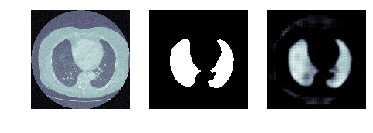

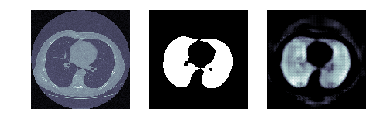

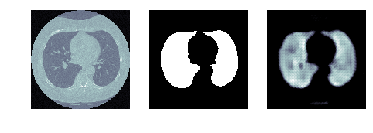

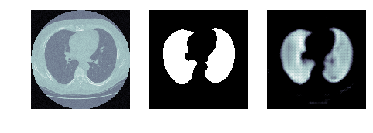

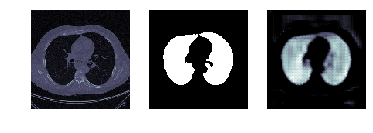

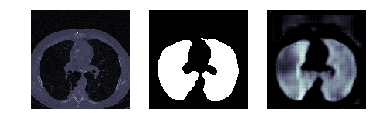

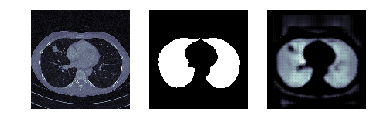

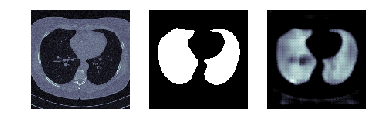

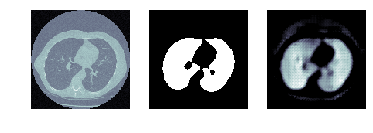

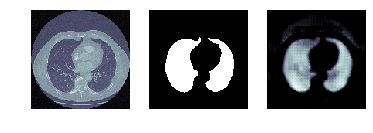

In [0]:




tick=10
while (tick>0):
  
  fig, (ax1, ax2, ax3) = plt.subplots(1,3)
  ax1.imshow(X_test[tick,0],cmap='bone')
  ax2.imshow(y_test[tick,0],cmap='bone')
  ax3.imshow(model.predict(X_test)[tick,0],cmap='bone')
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  tick=tick-1







In [0]:
print(hist.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_mean_squared_error', 'loss', 'acc', 'mean_squared_error', 'lr'])


### Plotting changes in parameters

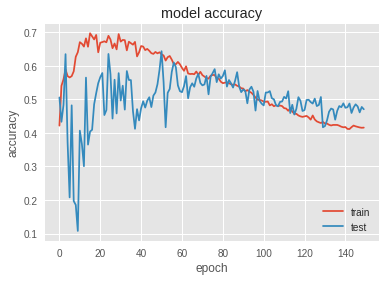

In [0]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

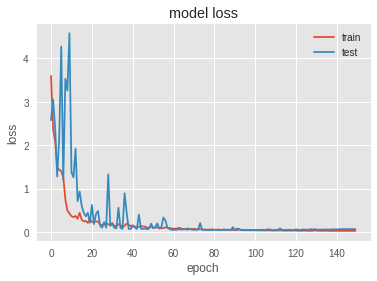

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Post-processing
> **Weighted Gaussian blurring**

> > A Gaussian kernel of size **5x5** is defineed to remove Gaussian noise from the output image. Blurring in OpenCv uses a low-pass filter to remove high frequency noise and sharp edges from image. The standard deviation in both the axes is set as zero for these images, thus every elements in the **5x5** kernel is same as the collective mean. The gaussian image is then added to the original image with 


>> **Gaussian kernel of size 3x3:**


>>> ![alt text](https://2.bp.blogspot.com/-WtMnUcoyNYc/WpdaYw7WUYI/AAAAAAAAI6s/lnF7SrQext0s51JoTt7VOhrD058osWkqgCLcBGAs/s320/3x3%2BGaussian%2BKernel.png)

>> 

> **Thresholding**

> > To form a clear and distinct image from the grayscale we threshold each pixel value against a determined value to get a binary image of only pure white and pure black pixels. This is done to resemble more like the desired output format which can be further used in medical purposes, neatly resembling the shape and size of lungs.

> **Erosion & island removal**

>> Islands of white pixels on the black backdrop are detected and correspondingly marked accordingly using Breadth-First-Search approach. On detection of these islands, we find their area and correspondingly remove small islands from the image by reseting their pixel values to 0.

>>After thresholding against area size, to remove any possibility of bigger unwanted islands which were not removed in the thresholding step, we take the top two biggest islands corresponding to two lungs in the resultant image and reset all other pixels to 0.

>>>![alt text](https://image.ibb.co/fLugcT/isl.jpg)


>## Final Results

> ![alt text](https://image.ibb.co/ddzi7T/obs.jpg)







In [0]:
from scipy.ndimage import measurements
from PIL import Image
import cv2
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return Image.point(contrast)

  
def unsharp_mask(img, blur_size = (10,10), imgWeight = 1.5, gaussianWeight = -0.5):
    gaussian = cv2.GaussianBlur(img, (5,5), 0)
    return cv2.addWeighted(img, imgWeight, gaussian, gaussianWeight, 0)

def clarify(img, threshold_factor=1.605, isImage=False, rigid=False):
  if not isImage:
    img = unsharp_mask(img)
    img = np.where(img*254 > 254, 254, img*254).astype('int32')
  
  if rigid:
    img = np.where(img > np.max(img)//threshold_factor, np.max(img), 0)
  else:
    img = np.where(img > np.max(img)//threshold_factor, np.max(img), img//threshold_factor**2)
  
  return img


def advanced_remove_islands(img, threshold=5, min_num=3, minsize=500):
  img = clarify(img, threshold, rigid=True)
  cluster_graph, n_clusters = measurements.label(img)
  clusters, counts = np.array(np.unique(cluster_graph, return_counts=True))[:,1:]
  
  keep_clusters = clusters[counts.argsort()[-min_num:][::-1]]
  
  
  for i in range(n_clusters):
      if(counts[i] < minsize):
          cluster_graph[cluster_graph == clusters[i]] = 0
  
  for cluster in clusters:
      if cluster in keep_clusters:
          cluster_graph[cluster_graph == cluster] = 255
      else:
          cluster_graph[cluster_graph == cluster] = 0
  
  return cluster_graph





In [0]:

tick=10
for tick in range(11):
  
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
  ax1.imshow(X_test[tick,0],cmap='bone')
  ax2.imshow(y_test[tick,0],cmap='gray')
  ax3.imshow(clarify(model.predict(X_test)[tick,0]),cmap='gray',)
  ax4.imshow(advanced_remove_islands(model.predict(X_test)[tick,0], 4, 2, 500),cmap='gray',)
  
  
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')

  if tick == 0:
    ax1.set_title('CT scan', fontsize=12)
    ax2.set_title('actual', fontsize=12)
    ax3.set_title('predicted', fontsize=12)
    ax4.set_title('masked', fontsize=12)
  else:
    pass
  
  
  

NameError: ignored

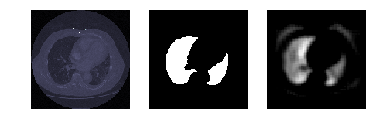

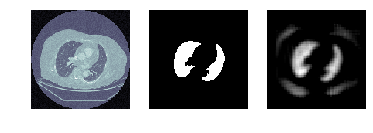

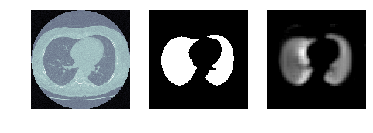

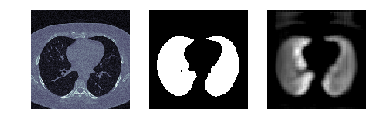

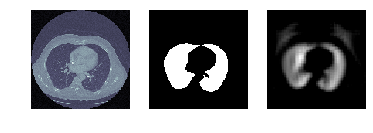

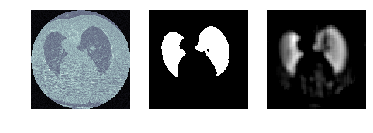

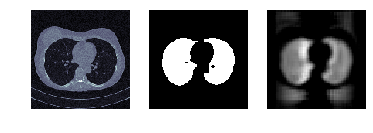

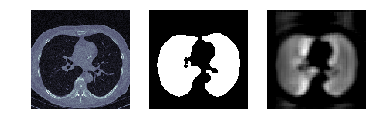

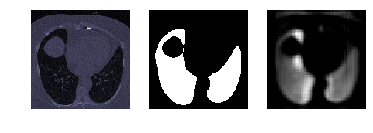

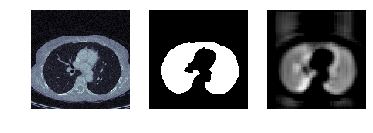

In [0]:
tick=10
while (tick>0):
  
  fig, (ax1, ax2, ax3) = plt.subplots(1,3)
  ax1.imshow(X_test[tick,0],cmap='bone')
  ax2.imshow(y_test[tick,0],cmap='gray')
  ax3.imshow(model.predict(X_test)[tick,0],cmap='gray',)
  
  
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  tick=tick-1

##  References



1.   @inproceedings{milletari2016v,
  title={V-net: Fully convolutional neural networks for volumetric medical image segmentation},
  author={Milletari, Fausto and Navab, Nassir and Ahmadi, Seyed-Ahmad},
  booktitle={3D Vision (3DV), 2016 Fourth International Conference on},
  pages={565--571},
  year={2016},
  organization={IEEE}
}

    Fausto Milletari, Nassir Navab, Seyed-Ahmad Ahmadi :  
    V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation
    
    In this work, the authors propose an approach to 3D image segmentation based on a CNN is trained end-to-end on MRI volumes depicting prostate, and learns to predict segmentation for the whole volume at once. 
    
2.   @article{litjens2017survey,
  title={A survey on deep learning in medical image analysis},
  author={Litjens, Geert and Kooi, Thijs and Bejnordi, Babak Ehteshami and Setio, Arnaud Arindra Adiyoso and Ciompi, Francesco and Ghafoorian, Mohsen and van der Laak, Jeroen AWM and Van Ginneken, Bram and S{\'a}nchez, Clara I},
  journal={Medical image analysis},
  volume={42},
  pages={60--88},
  year={2017},
  publisher={Elsevier}
}

    Geert Litjens, Thijs Kooi, Babak Ehteshami Bejnordi, Arnaud Arindra Adiyoso Setio, Francesco Ciompi,
Mohsen Ghafoorian, Jeroen A.W.M. van der Laak, Bram van Ginneken, Clara I. Sanchez :  A Survey on Deep Learning in Medical Image Analysis

     This paper reviews the major deep learning concepts pertinent to medical image analysis
and summarizes over 300 contributions to the field. It summarizes the current state-of-the-art and a critical discussion for open challenges and areas of future research.

3.   @inproceedings{xu2014deep,
  title={Deep learning of feature representation with multiple instance learning for medical image analysis},
  author={Xu, Yan and Mo, Tao and Feng, Qiwei and Zhong, Peilin and Lai, Maode and Eric, I and Chang, Chao},
  booktitle={Acoustics, Speech and Signal Processing (ICASSP), 2014 IEEE International Conference on},
  pages={1626--1630},
  year={2014},
  organization={IEEE}
}

      Yan Xu, Tao Mo, Qiwei Feng, Peilin Zhong, Maode Lai, Eric I-Chao Chang : DEEP LEARNING OF FEATURE REPRESENTATION WITH MULTIPLE INSTANCE
LEARNING FOR MEDICAL IMAGE ANALYSIS

      This paper studies the effectiveness of accomplishing high-level
tasks with a minimum of manual annotation and good feature representations
for medical images. The automatic extraction of feature representation through Deep Learning (DNN) is being studied which draws the following conclusions: (1) automatic feature learning outperforms manual feature; (2) the unsupervised approach can achieve performance that’s close to fully supervised approach (93.56%) vs. (94.52%); and (3) the MIL performance of coarse label (96.30%) outweighs the supervised performance of fine label (95.40%) in supervised deep learning features.

4.    @inproceedings{ronneberger2015u,
  title={U-net: Convolutional networks for biomedical image segmentation},
  author={Ronneberger, Olaf and Fischer, Philipp and Brox, Thomas},
  booktitle={International Conference on Medical image computing and computer-assisted intervention},
  pages={234--241},
  year={2015},
  organization={Springer}
}


      Olaf Ronneberger, Philipp Fischer, and Thomas Brox : U-Net: Convolutional Networks for Biomedical Image Segmentation
      
      In this paper, the authors present a network and training strategy that relies on the strong use of data augmentation to use the available annotated samples more efficiently. The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization. They show that such a network can be trained end-to-end from very few images and outperforms the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks.
      
5.    @article{milletari2017hough,
  title={Hough-CNN: deep learning for segmentation of deep brain regions in MRI and ultrasound},
  author={Milletari, Fausto and Ahmadi, Seyed-Ahmad and Kroll, Christine and Plate, Annika and Rozanski, Verena and Maiostre, Juliana and Levin, Johannes and Dietrich, Olaf and Ertl-Wagner, Birgit and B{\"o}tzel, Kai and others},
  journal={Computer Vision and Image Understanding},
  volume={164},
  pages={92--102},
  year={2017},
  publisher={Elsevier}
}

      Fausto Milletaria, Seyed-Ahmad Ahmadi, Christine Kroll, Annika Plate, Verena Rozanski, Juliana Maiostre, Johannes Levin, Olaf Dietrich, Birgit Ertl-Wagner , Kai B¨otzel, Nassir Navab : Hough-CNN: Deep Learning for Segmentation of Deep
Brain Regions in MRI and Ultrasound

      In this work, the authors propose a novel approach to perform segmentation by leveraging the abstraction capabilities of convolutional neural networks (CNNs). Their method is based on Hough voting, a strategy that allows for fully automatic localisation and segmentation of the anatomies of interest. This approach does not only use the CNN classification outcomes, but it also implements voting by exploiting the features produced by the deepest portion of the network.
      
6.    @article{christ2017automatic,
  title={Automatic liver and tumor segmentation of ct and mri volumes using cascaded fully convolutional neural networks},
  author={Christ, Patrick Ferdinand and Ettlinger, Florian and Gr{\"u}n, Felix and Elshaera, Mohamed Ezzeldin A and Lipkova, Jana and Schlecht, Sebastian and Ahmaddy, Freba and Tatavarty, Sunil and Bickel, Marc and Bilic, Patrick and others},
  journal={arXiv preprint arXiv:1702.05970},
  year={2017}
}

        Patrick Ferdinand Christ, Florian Ettlinger, Felix Gr¨un, Mohamed Ezzeldin A.
Elshaer, Jana Lipkov´a, Sebastian Schlecht, Freba Ahmaddy, Sunil Tatavarty, Marc Bickel, Patrick Bilic, Markus Rempfler, Felix Hofmann, Melvin D’Anastasi, Seyed-Ahmad Ahmadi, Georgios Kaissis, Julian Holch, Wieland Sommer, Rickmer Braren, Volker Heinemann, Bjoern Menze  :  Automatic Liver and Tumor Segmentation of CT and MRI
Volumes Using Cascaded Fully Convolutional Neural Networks

        This paper presents a method to automatically segment liver and lesions in CT and
MRI abdomen images using cascaded fully convolutional neural networks (CFCNs) enabling the segmentation of large-scale medical trials and quantitative image analyses. The authors train and cascade two FCNs for the combined segmentation of the liver and its lesions. As a first step, they train an FCN to segment the liver as ROI input for a second FCN. The second FCN solely segments lesions within the predicted liver ROIs of step 1. CFCN models were trained on an abdominal CT dataset comprising 100 hepatic tumor volumes.

7.    @article{kayalibay2017cnn,
  title={CNN-based segmentation of medical imaging data},
  author={Kayalibay, Baris and Jensen, Grady and van der Smagt, Patrick},
  journal={arXiv preprint arXiv:1701.03056},
  year={2017}
}

        Baris Kayalibay, Grady Jensen, Patrick van der Smagt : CNN-based Segmentation of Medical Imaging Data
        
        In this work, a CNN-based method with three-dimensional filters is demonstrated
and applied to hand and brain MRI. Two modifications to an existing CNN architecture are discussed, along with methods on addressing the aforementioned challenges.

8.      @article{roth2017hierarchical,
  title={Hierarchical 3D fully convolutional networks for multi-organ segmentation},
  author={Roth, Holger R and Oda, Hirohisa and Hayashi, Yuichiro and Oda, Masahiro and Shimizu, Natsuki and Fujiwara, Michitaka and Misawa, Kazunari and Mori, Kensaku},
  journal={arXiv preprint arXiv:1704.06382},
  year={2017}
}

          Holger R. Roth, Hirohisa Oda, Yuichiro Hayashi, Masahiro Oda, Natsuki Shimizu, Michitaka Fujiwara, Kazunari Misawa and Kensaku Mori : Hierarchical 3D fully
convolutional networks for multi-organ segmentation

          In this work, the authors show that a multi-class 3D FCN trained on manually labeled CT scans of seven abdominal structures (artery, vein, liver, spleen, stomach, gallbladder, and
pancreas) can achieve competitive segmentation results, while avoiding the need for handcrafting features or training organ-specific models. The models were tested on a completely unseen data collection acquired at a different hospital that includes 150 CT scans with three anatomical labels (liver, spleen, and pancreas). In such challenging organs as the pancreas, our hierarchical approach improves the mean Dice score from 68.5 to 82.2%, achieving the highest reported average score on this dataset.

9.      @article{chen2017voxresnet,
  title={VoxResNet: Deep voxelwise residual networks for brain segmentation from 3D MR images},
  author={Chen, Hao and Dou, Qi and Yu, Lequan and Qin, Jing and Heng, Pheng-Ann},
  journal={NeuroImage},
  year={2017},
  publisher={Elsevier}
}

          Hao Chen, Qi Dou, Lequan Yu, Jing Qin, Pheng-Ann Heng : VoxResNet: Deep voxelwise residual networks for brain segmentation from 3D MR images
          
          The authors propose a novel voxelwise residual network (VoxResNet) with a set of effective training schemes to cope with the problem of brain segmentation. The main merit of residual learning is that it can alleviate the degradation problem when training a deep network so that the performance gains achieved by increasing the network depth can be fully leveraged. With this
technique, the VoxResNet is built with 25 layers, and hence can generate more representative features to deal with the large variations of brain tissues than its rivals using hand-crafted features or shallower networks.

10.     @article{hu2001automatic,
  title={Automatic lung segmentation for accurate quantitation of volumetric X-ray CT images},
  author={Hu, Shiying and Hoffman, Eric A and Reinhardt, Joseph M},
  journal={IEEE transactions on medical imaging},
  volume={20},
  number={6},
  pages={490--498},
  year={2001},
  publisher={IEEE}
}

          Shiying Hu, Eric A. Hoffman, and Joseph M. Reinhardt : Automatic Lung Segmentation for Accurate Quantitation of Volumetric X-Ray CT Images
          
          This paper presents a fully automatic method for identifying the lungs in three-dimensional (3-D) pulmonary X-ray CT images. The method has three main steps. First, the lung region is extracted from the CT images by gray-level thresholding. Then, the left and right lungs are separated by identifying the anterior and posterior junctions by dynamic programming. Finally, a sequence of morphological operations is used to smooth the irregular boundary along the mediastinum in order to obtain results consistent with those obtained by manual analysis, in which only the most central pulmonary arteries are excluded from the lung
region.